# CITE-seq analysis

With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, integrate datasets, and compute differential expression of RNA and protein. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.

If you use totalVI, please consider citing:

* Gayoso, Adam, et al. "Joint probabilistic modeling of paired transcriptome and proteome measurements in single cells." bioRxiv (2020).



## Imports and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.)

In [37]:
#adata = scvi.data.cortex(run_setup_anndata=False)
adata = scvi.data.spleen_lymph_cite_seq(run_setup_anndata=False)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     File data/sln_111.h5ad already downloaded                                           
INFO     File data/sln_208.h5ad already downloaded                                           


/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [38]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=4000, 
    flavor="seurat_v3",
    batch_key="batch", 
    subset=True,
    layer="counts"
)

/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ec

In [39]:
adata.obsm

AxisArrays with keys: isotypes_htos, protein_expression

In [40]:
scvi.data.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="batch", 
    protein_expression_obsm_key="protein_expression"
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Successfully registered anndata object containing 32648 cells, 4000 vars, 4 batches,
         1 labels, and 110 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Prepare and run model

In [41]:
vae = scvi.model.TOTALVI(adata, use_cuda=True, latent_distribution="normal")

/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
vae.train()

INFO     Training for 400 epochs.                                                            
INFO     KL warmup for 24486.0 iterations                                                    
Training...:   2%|▏         | 9/400 [02:24<1:45:09, 16.14s/it]

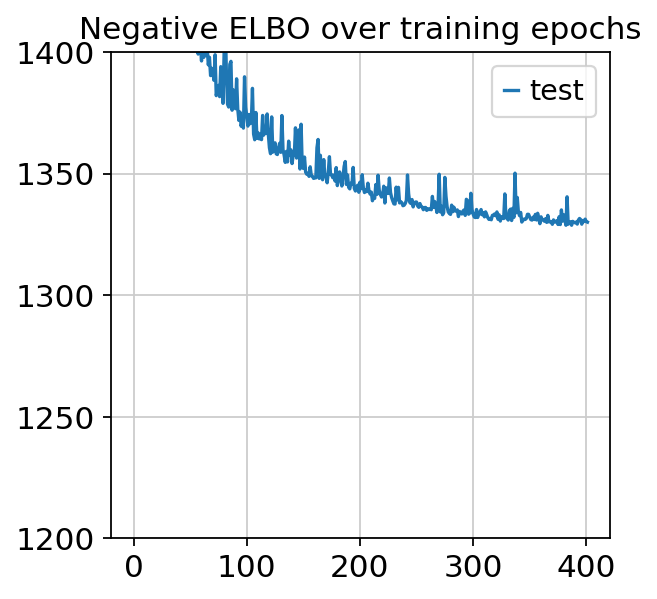

In [39]:
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1200, 1400)
plt.legend()

## Analyze outputs

We use Scanpy for clustering and visualization after running totalVI. It's also possible to save totalVI outputs for an R-based workflow. First, we store the totalVI outputs in the appropriate slots in AnnData.

In [50]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25, 
    return_mean=True, 
    transform_batch=["PBMC10k", "PBMC5k"]
)

adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25, 
    return_mean=True, 
    transform_batch=["PBMC10k", "PBMC5k"]
)

print(adata.obsm["protein_expression"].columns)

parsed_protein_names = [p.decode().split("_")[0] for p in adata.obsm["protein_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

Index([   b'CD3_TotalSeqB',    b'CD4_TotalSeqB',   b'CD8a_TotalSeqB',
         b'CD14_TotalSeqB',   b'CD15_TotalSeqB',   b'CD16_TotalSeqB',
         b'CD56_TotalSeqB',   b'CD19_TotalSeqB',   b'CD25_TotalSeqB',
       b'CD45RA_TotalSeqB', b'CD45RO_TotalSeqB',   b'PD-1_TotalSeqB',
        b'TIGIT_TotalSeqB',  b'CD127_TotalSeqB'],
      dtype='object')


Now we can compute clusters and visualize the latent space.

In [51]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'batch' as categorical


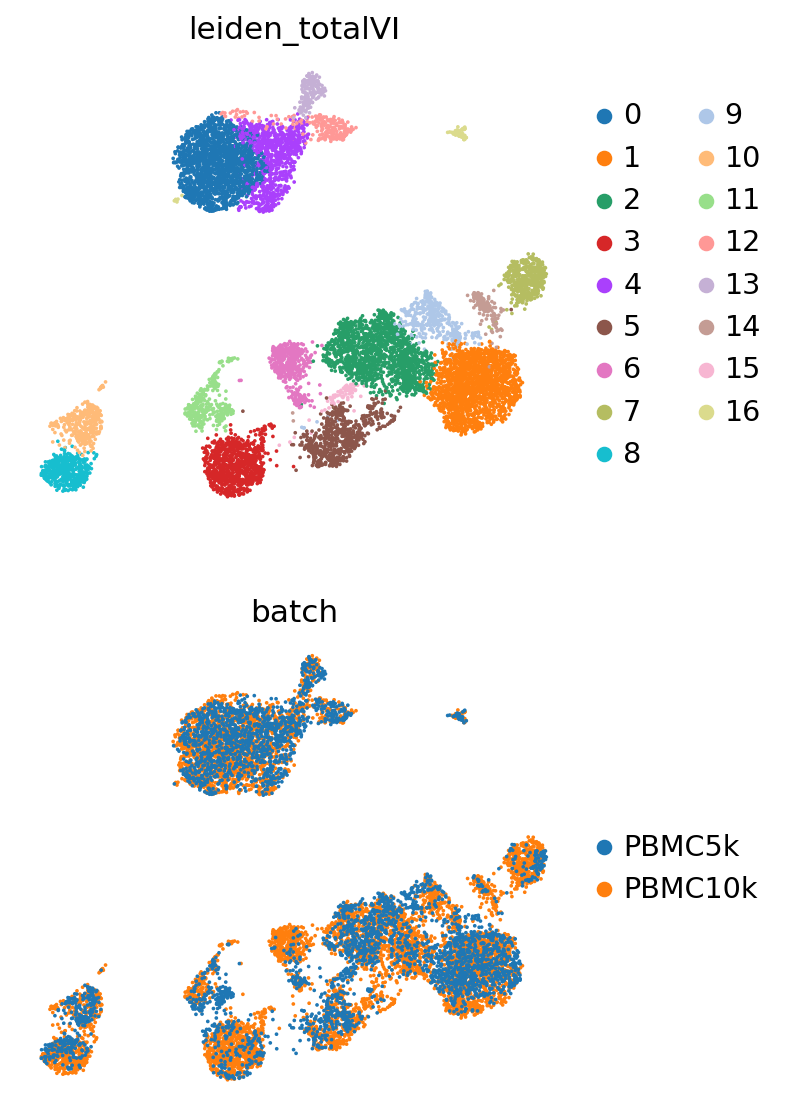

In [52]:
sc.pl.umap(
    adata, 
    color=["leiden_totalVI", "batch"], 
    frameon=False,
    ncols=1,
)

To visualize protein values on the umap, we make a temporary protein adata object. We have to copy over the umap from the original adata object.

In [53]:
pro_adata = sc.AnnData(adata.obsm["protein_expression"].copy(), obs=adata.obs)
sc.pp.log1p(pro_adata)
# Keep log normalized data in raw
pro_adata.raw = pro_adata
pro_adata.X = adata.obsm["denoised_protein"]
# these are cleaner protein names -- "_TotalSeqB" removed
pro_adata.var["protein_names"] = parsed_protein_names
pro_adata.obsm["X_umap"] = adata.obsm["X_umap"]
pro_adata.obsm["X_totalVI"] = adata.obsm["X_totalVI"]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [54]:
names = adata.obsm["protein_foreground_prob"].columns
for p in names:
    pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p] 

### Visualize denoised protein values 

In [55]:
sc.pl.umap(
    pro_adata, 
    color=pro_adata.var_names,
    gene_symbols="protein_names",
    ncols=3, 
    vmax="p99",
    use_raw=False,
    frameon=False,
    wspace=0.1
)

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

<Figure size 1056x1600 with 0 Axes>

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

<div class="alert alert-info">

Note

While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.

</div>

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

In [ ]:
sc.pl.umap(
    pro_adata,
    color=["{}_fore_prob".format(p) for p in parsed_protein_names],
    ncols=3,
    color_map="cividis",
    frameon=False,
    wspace=0.1
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster. The results for each of the one-vs-all tests is concatenated into one DataFrame object. Inividual tests can be sliced using the "comparison" column. Genes and proteins are included in the same DataFrame.

<div class="alert alert-info">

Important

We do not recommend using totalVI denoised values in other differential expression tools, as denoised values are a summary of a random quantity. The totalVI DE test takes into account the full uncertainty of the denoised quantities.

</div>

In [61]:
de_df = vae.differential_expression(
        groupby="leiden_totalVI", 
        delta=0.5,
        batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
b'HP',0.9920,0.0080,4.820280,0.000036,5.273830e-07,8.167307,8.389022,3.268630,-5.888277,24.211308,0.086594,0.001120,0.067814,0.001008,0.282799,0.002961,True,0 vs Rest
b'MARC1',0.9902,0.0098,4.615524,0.000134,3.944827e-06,8.831191,9.297632,3.181191,-3.465557,16.704298,0.365154,0.014219,0.275430,0.012875,1.383682,0.041717,True,0 vs Rest
b'BPI',0.9896,0.0104,4.555494,0.000021,7.870617e-07,6.541204,6.728895,2.394074,-4.803594,15.523086,0.056860,0.002463,0.050078,0.002351,0.161145,0.005885,True,0 vs Rest
b'SERPINB10',0.9890,0.0110,4.498798,0.000012,2.617677e-07,6.552815,6.657228,2.690414,-5.234659,16.704428,0.035994,0.001008,0.031821,0.000896,0.128603,0.002759,True,0 vs Rest
b'ANKRD34B',0.9868,0.0132,4.314250,0.000010,3.881705e-07,6.357409,6.535745,2.638217,-5.027596,16.678097,0.028169,0.001343,0.023996,0.001120,0.131581,0.004016,True,0 vs Rest


Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [67]:
filtered_pro = {}
filtered_rna = {}
cats = adata.obs.leiden_totalVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.astype(str).str.contains('TotalSeqB')
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

We can also use general scanpy visualization functions

In [68]:
sc.tl.dendrogram(adata, groupby="leiden_totalVI", use_rep="X_totalVI")
sc.tl.dendrogram(pro_adata, groupby="leiden_totalVI", use_rep="X_totalVI")

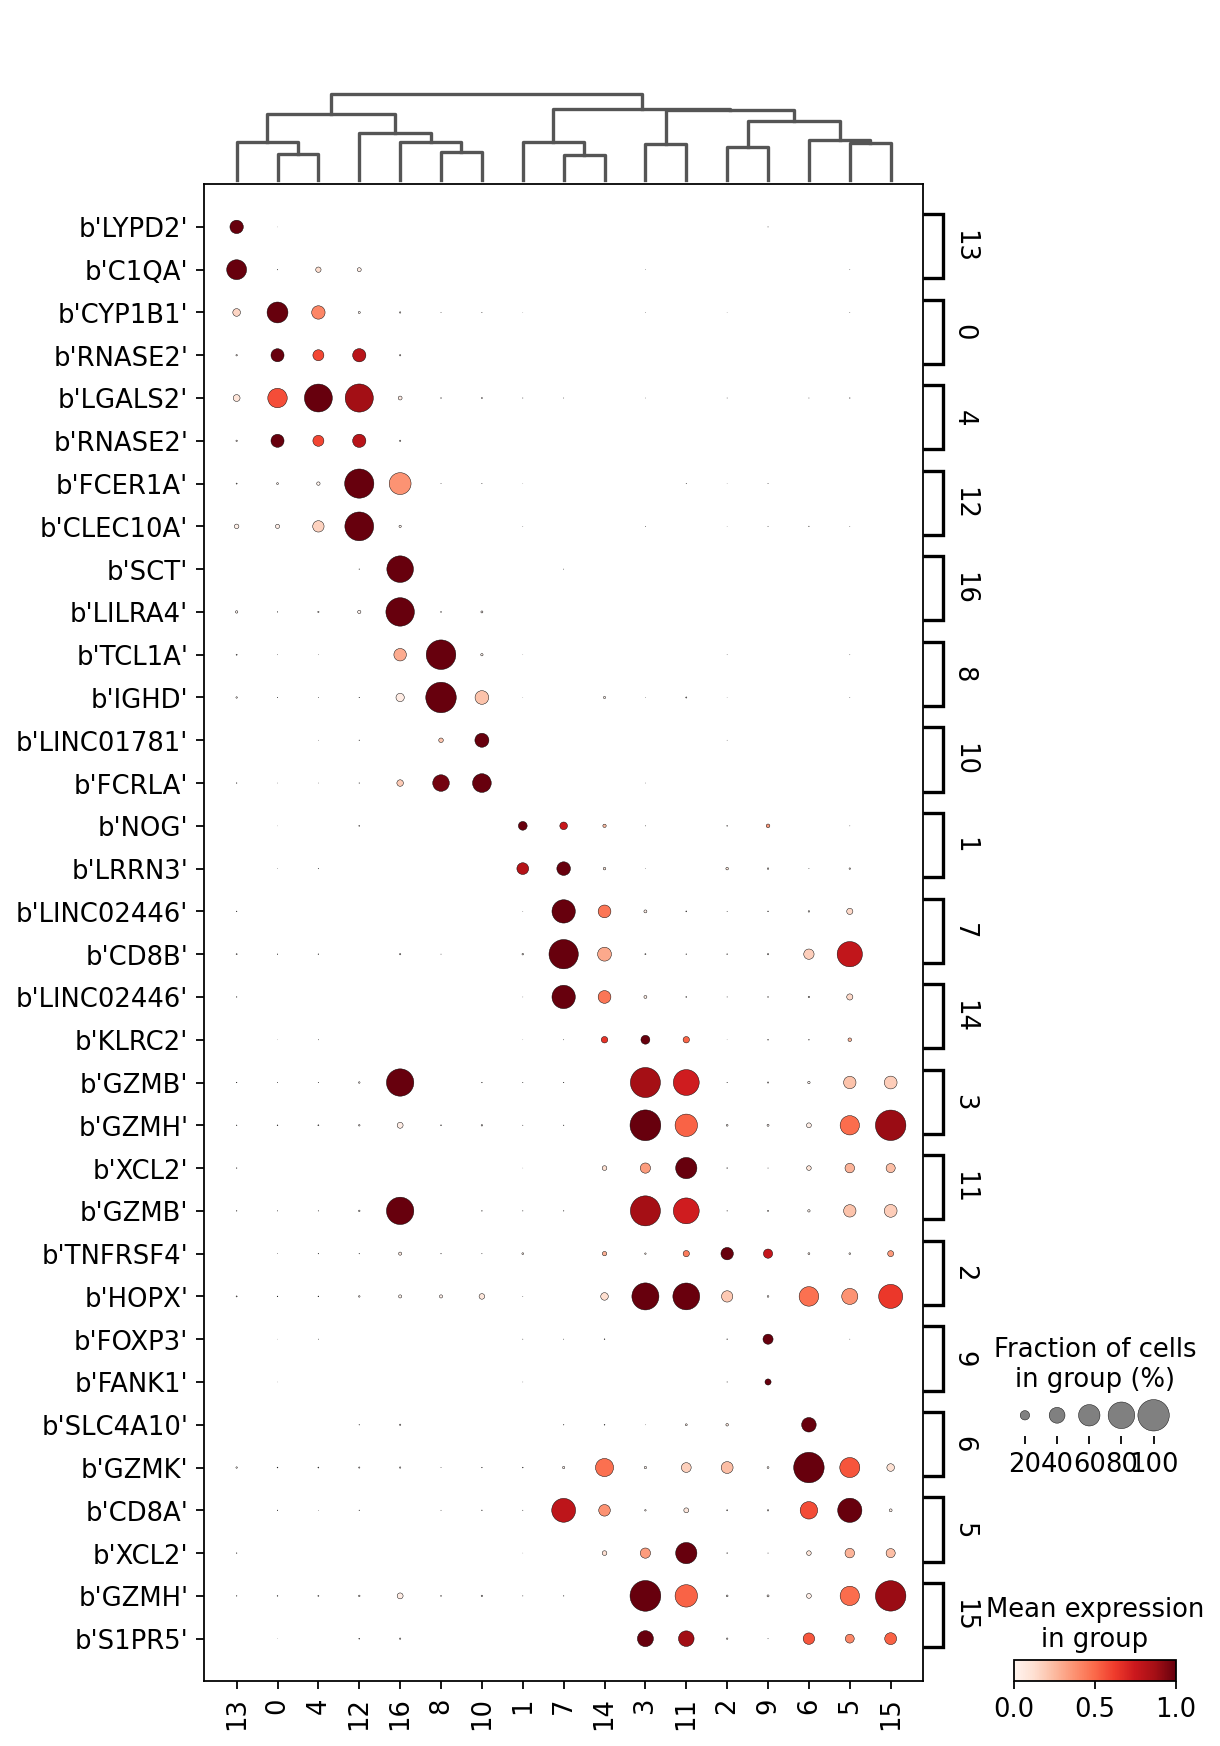

In [69]:
sc.pl.dotplot(
    adata, 
    filtered_rna, 
    groupby="leiden_totalVI", 
    dendrogram=True,
    standard_scale="var",
    swap_axes=True
)

Matrix plot displays totalVI denoised protein expression per leiden cluster.

/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/ecyoo/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


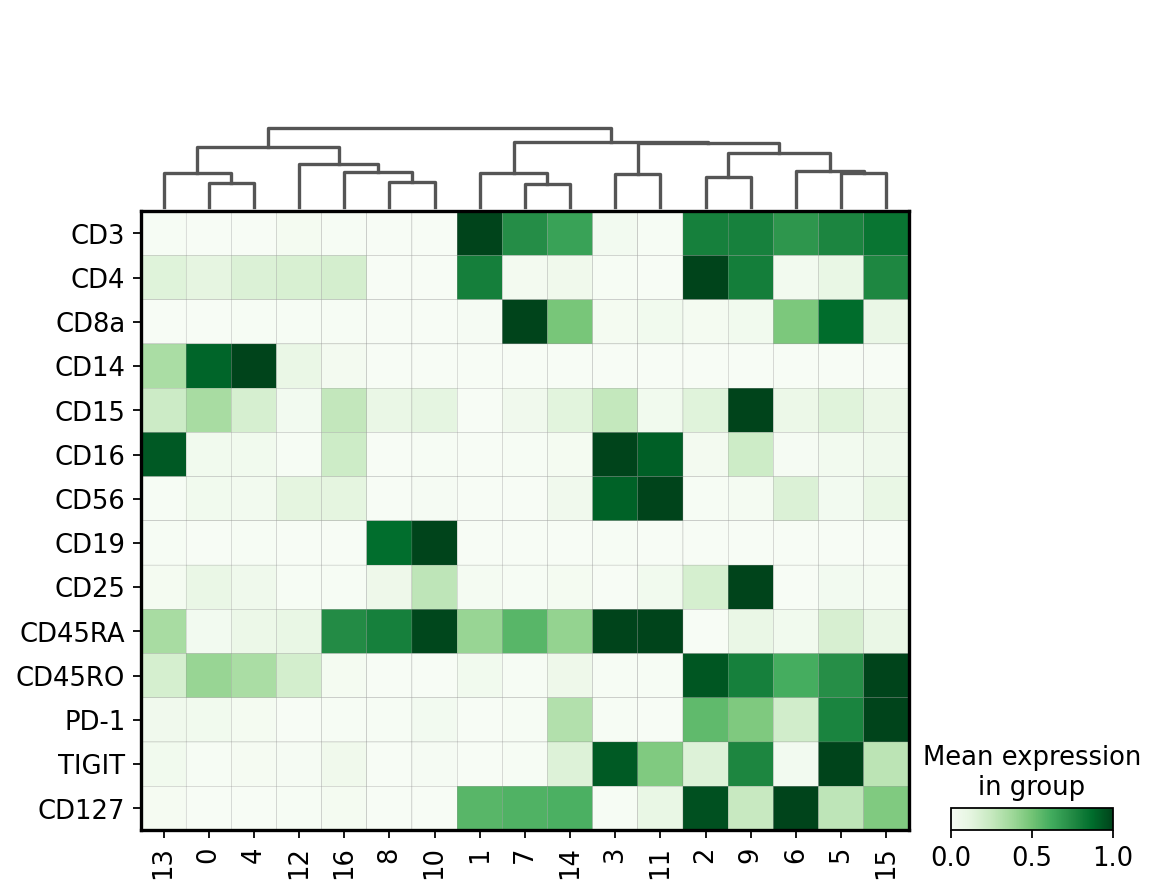

In [70]:
sc.pl.matrixplot(
    pro_adata,
    pro_adata.var["protein_names"],
    groupby="leiden_totalVI",
    gene_symbols="protein_names",
    dendrogram=True,
    swap_axes=True,
    use_raw=False, # use totalVI denoised
    cmap="Greens",
    standard_scale="var"
)

This is a selection of some of the markers that turned up in the RNA DE test. 

In [ ]:
sc.pl.umap(
    adata, 
    color=[
           "leiden_totalVI", 
           "IGHD", 
           "FCER1A", 
           "SCT", 
           "GZMH", 
           "NOG", 
           "FOXP3", 
           "CD8B",
           "C1QA", 
           "SIGLEC1", 
           "XCL2", 
           "GZMK", 
           ], 
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.1
)